In [3]:
# from urllib2.request import urlopen
import requests
import json
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import dateutil
import pytz
from sklearn import linear_model, cross_validation
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
Chicago=pytz.timezone("America/Chicago")
Chicago
N_priordays=5

In [5]:
def get_prices(startDate,endDate=None):
    '''
    gets data from ComEd
    startDate and endDate should be in YYYYMMDDhhmm
    output is a list of {"1234",5.5}, where "1234" is the UTC in seconds and 5.5 is the price
    '''
    endDate = startDate if endDate is None else endDate
    startDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(startDate)))
    endDate=Chicago.normalize(Chicago.localize(dateutil.parser.parse(endDate)))
    format="%Y%m%d%H%M"
    startDate=startDate.strftime(format)
    endDate=endDate.strftime(format)
    URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart=STARTDATE&dateend=ENDDATE&format=json"
    temp=URL.replace("STARTDATE",startDate).replace("ENDDATE",endDate)
    print(temp)
    r = requests.get(url=temp)
    data = r.json()
#     print [int(obj.values()[1])/1000 for obj in data]
    out={}
    for obj in data:
        try:
            ts=int(obj.values()[1])/1000
            dt=Chicago.normalize(Chicago.localize(datetime.datetime.fromtimestamp(ts)))
            out[dt]=float(obj.values()[0])
        except Exception:
            pass
#     print out
    return out        

In [6]:
startDate="20171101"
endDate="20171115"

data=get_prices(startDate,endDate)
print(str(len(data.keys()))+" records of data")

https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201711010000&dateend=201711150000&format=json
3947 records of data


In [7]:
for k in data:
    print(k)
    print(type(data[k]))
    print(type(k))
    break
print(len(data))

2017-11-08 22:35:00-06:00
<type 'float'>
<type 'datetime.datetime'>
3947


In [8]:
def inrange(indatetime):
    '''
    returns true if datetime is between midnight and 5 AM, and a weekday
    '''
    hourflag=(datetime.time(23,0,0)<=indatetime.time()) or (indatetime.time()<=datetime.time(5,0,0))
    dayflag=0<=indatetime.weekday()<=4
    return hourflag and dayflag

In [9]:
# dates=sorted([dt for dt in data.keys() if inrange(dt)])
dates=sorted([dt for dt in data.keys()])
print(len(dates))
dates[0]
print(dates[0] - datetime.timedelta(minutes=5))
# data[2017-11-01 00:00:00-05:00]

3947
2017-10-31 23:55:00-05:00


In [11]:
y=[]
A=[]
indices=[]
count=0
historical_N=range(1,N_priordays+1)
final = {'date':[], 'price':[], 'prior':[], 'historical_average_price':[]}
for dt in range(len(dates)):
    try:
        price=data[dates[dt]]
        final['date'].append(dates[dt])
        final['price'].append(price)
        prior=dates[dt]-datetime.timedelta(minutes=5)
#         print(prior)
        prior_price=data[prior]
        final['prior'].append(prior_price)
#         print(prior_price)
        historical=[dates[dt]-datetime.timedelta(days=n) for n in historical_N]
#         print(historical)
        historical_price=[data[h] for h in historical]
#         print(historical_price)
        historical_average=np.average(historical_price)
        final['historical_average_price'].append(historical_average)
#         print(historical_average)
        y.append([price])
#         print(y)
        A.append([prior_price,historical_average,1])
#         print(A)
        indices.append(dates[dt])
    except Exception:
        count+=1
#         print("in exception with dt="+str(dt))
        pass
print(count)
A=np.matrix(A)
y=np.matrix(y)

1710


In [12]:
len(final['historical_average_price'])

2237

In [13]:
df = pd.DataFrame.from_dict(final, orient='index').T.dropna()

In [14]:
df = df.dropna()
df.set_index('date')

,prior,price,historical_average_price
date,,,
2017-11-01 00:00:00-05:00,2.4,2.4,1.9
2017-11-01 00:05:00-05:00,2,2,2.04
2017-11-01 00:10:00-05:00,2.2,2.2,2
2017-11-01 00:15:00-05:00,2.1,2.1,1.94
2017-11-01 00:20:00-05:00,2,2,1.98
2017-11-01 00:25:00-05:00,2.3,2.3,2.14
2017-11-01 00:30:00-05:00,2.1,2.1,2.16
2017-11-01 00:35:00-05:00,2.1,2.1,2.14
2017-11-01 00:40:00-05:00,2.2,2.2,2.08


In [15]:
df.date = pd.to_datetime(df.date)
df.date.head()

0   2017-11-01 00:00:00-05:00
1   2017-11-01 00:05:00-05:00
2   2017-11-01 00:10:00-05:00
3   2017-11-01 00:15:00-05:00
4   2017-11-01 00:20:00-05:00
Name: date, dtype: datetime64[ns, America/Chicago]

In [16]:
df[:5]

,date,prior,price,historical_average_price
0,2017-11-01 00:00:00-05:00,2.4,2.4,1.9
1,2017-11-01 00:05:00-05:00,2,2,2.04
2,2017-11-01 00:10:00-05:00,2.2,2.2,2
3,2017-11-01 00:15:00-05:00,2.1,2.1,1.94
4,2017-11-01 00:20:00-05:00,2,2,1.98


In [17]:
# print("y:\n"+str(y))
# print("A:\n"+str(A))
print(len(y), len(A))
A_inv=np.linalg.pinv(A)
x=np.dot(A_inv,y)
Ax=np.dot(A,x)
err=y-Ax
print("x:\n"+str(x))
#print("err:\n"+str(err))
print("dim(y): "+str(y.shape))
print("dim(Ax): "+str(Ax.shape))
print("dim(err): "+str(err.shape))
print("dim(indices): "+str(len(indices)))

(2237, 2237)
x:
[[ 0.71445359]
 [ 0.14062958]
 [ 0.49045139]]
dim(y): (2237, 1)
dim(Ax): (2237, 1)
dim(err): (2237, 1)
dim(indices): 2237


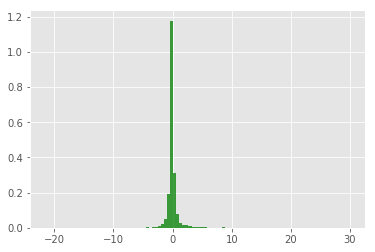

In [18]:
plt.hist(err, 100, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [19]:
orig = df

In [20]:
target = df['price']
dates = df['date']
print(target.head())
print(dates.head())

0    2.4
1      2
2    2.2
3    2.1
4      2
Name: price, dtype: object
0   2017-11-01 00:00:00-05:00
1   2017-11-01 00:05:00-05:00
2   2017-11-01 00:10:00-05:00
3   2017-11-01 00:15:00-05:00
4   2017-11-01 00:20:00-05:00
Name: date, dtype: datetime64[ns, America/Chicago]


In [21]:
dates[0]

Timestamp('2017-11-01 00:00:00-0500', tz='America/Chicago')

In [22]:
df = df.drop('price', axis=1)

In [31]:
df = df.drop('date', axis=1)

In [23]:
df.head()

,date,prior,historical_average_price
0,2017-11-01 00:00:00-05:00,2.4,1.9
1,2017-11-01 00:05:00-05:00,2,2.04
2,2017-11-01 00:10:00-05:00,2.2,2
3,2017-11-01 00:15:00-05:00,2.1,1.94
4,2017-11-01 00:20:00-05:00,2,1.98


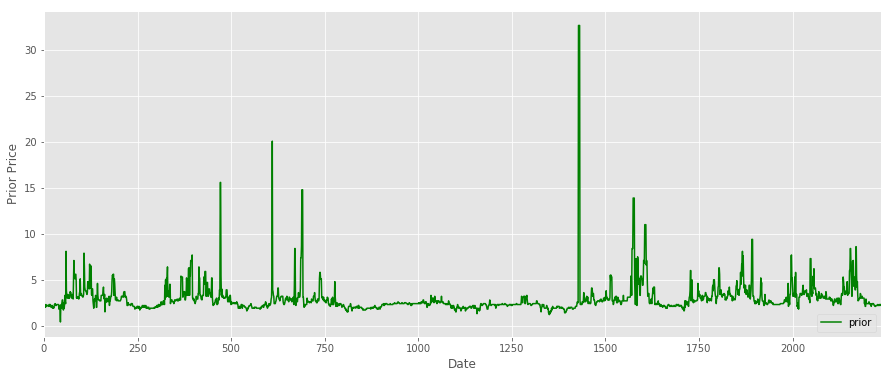

In [24]:
df['prior'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Prior Price')
plt.show()

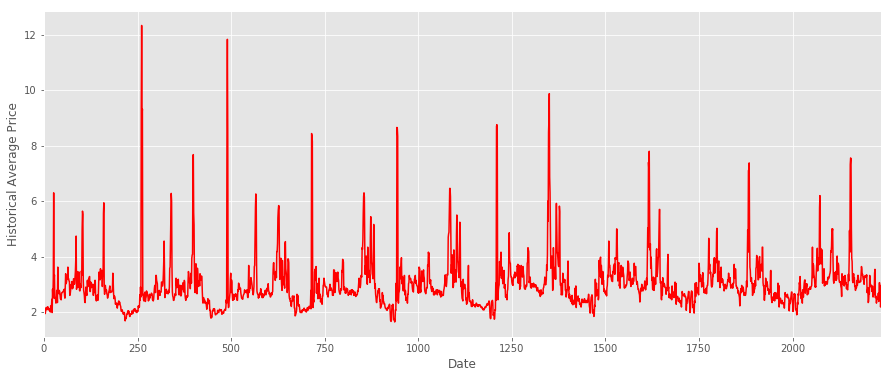

In [25]:
df['historical_average_price'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('Historical Average Price')
plt.show()

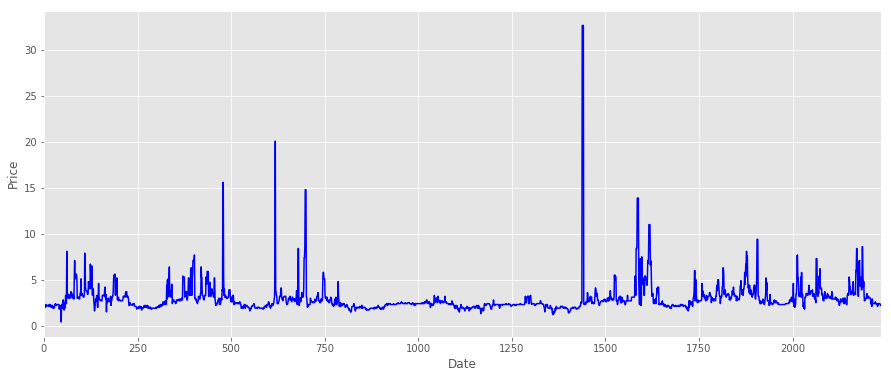

In [26]:
target.plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [46]:
df_train,df_test,target_train,target_test = cross_validation.train_test_split(df, target, test_size = 0.3)

In [47]:
print('length of X_train and x_test: ', len(df_train), len(df_test))

('length of X_train and x_test: ', 1565, 672)


In [48]:
regr = linear_model.LinearRegression()

In [49]:
regr.fit(df_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
accuracy = regr.score(df_test, target_test)
print("Accuracy of Linear Regression: ", accuracy)

('Accuracy of Linear Regression: ', 0.014284544180834802)


In [38]:
# Make predictions using the testing set
price_pred = regr.predict(df_test)

(array([ 415.,   24.,    3.,    1.,    4.,    0.,    0.,    0.,    0.,    1.]),
 array([ 2.72998835,  3.20507451,  3.68016067,  4.15524683,  4.63033299,
         5.10541915,  5.5805053 ,  6.05559146,  6.53067762,  7.00576378,
         7.48084994]),
 <a list of 10 Patch objects>)

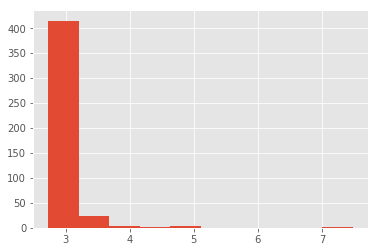

In [52]:
plt.hist(price_pred)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, price_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, price_pred))

In [ ]:
# Plot outputs
plt.scatter(df_test.historical_average_price, target_test,  color='black')
plt.plot(df_test.historical_average_price, price_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
np.savetxt("err.csv", ERR, delimiter=",")

In [ ]:
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

t = np.arange(0.0, 100.0, 0.1)
s = np.sin(2*np.pi*t)
l, = plt.plot(t,s)
plt.axis([0, 10, -1, 1])

axcolor = 'lightgoldenrodyellow'
axpos = plt.axes([0.2, 0.1, 0.65, 0.03], axisbg=axcolor)

spos = Slider(axpos, 'Pos', 0.1, 90.0)

def update(val):
    pos = spos.val
    ax.axis([pos,pos+10,-1,1])
    fig.canvas.draw_idle()

spos.on_changed(update)

plt.show()